This code serves to visualise the peaks with human input disportion modes. (like isovisq)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from importlib import reload
import visualiser_function
reload(visualiser_function)
from visualiser_function import shift_atoms, transform_list_hkl_p63_p65, get_structure_factors , atom_position_list , shift_atoms_copy
from itertools import chain
from matplotlib.markers import MarkerStyle
from tqdm import tqdm
from time import time


In [2]:
#convert the simulated data to log10 scale

def log10(x):
  numerator = tf.math.log(x)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

In [4]:
def fun_tf(hkl_list, pars, matrix):
    """
    Fast computation of structure factors with parameter-dependent structure.
    """

    # Get modified structure
    pars_tensor = tf.stack(pars)  # shape (params,)
    #Continue with TensorFlow ops
    t0 = time()
    atom_shift_list = shift_atoms(matrix , (pars_tensor))
    print(f"Time taken for shift_atoms: {time() - t0:.4f} seconds")
    print(f"atom_shift_list first thing: {atom_shift_list[0]}")
    print(f"Shape of atom_shift_list: {len(atom_shift_list)}")
    atom_shift_list = atom_shift_list[:,0]
    print(f"hahahah={type(atom_shift_list)}")


    # t0 = time()
    # atom_shift_list_copy = shift_atoms_copy(*tf.unstack(pars_tensor))
    # print(atom_shift_list_copy)
    # print(f"Time taken for shift_atoms_copy: {time() - t0:.4f} seconds")




    # Flatten atom_shift_list if it contains nested lists
    # flat_atom_shift_list = list(chain.from_iterable(
    #     x if isinstance(x, list) else [x] for x in atom_shift_list
    # ))

    t1 = time()
    modified_struct = atom_position_list(*atom_shift_list)
    print(f"Time taken for atom_position_list: {time() - t1:.4f} seconds")

    parent_hkl = hkl_list
    hkl_list = transform_list_hkl_p63_p65(hkl_list)
    print(f"Shape of hkl_list: {hkl_list.shape}")

    # Get structure factors
    t2 = time()
    sf_hkl = get_structure_factors(hkl_list, modified_struct)
    print(f"Time taken for get_structure_factors: {time() - t2:.4f} seconds")

    print(f"Shape of sf_hkl: {sf_hkl.shape}")
    intensity = (abs(sf_hkl)) ** 2

    w = tf.constant(0.00032001553565274784, dtype=tf.float32)  # Debye-Waller factor 
    qnorms = tf.norm(tf.cast(hkl_list, tf.float32), axis=1)
    intensity = intensity * tf.exp(- w* qnorms ** 2)  # Apply Debye-Waller factor
    #intensity = log10(intensity + 1)  # Convert to log10 scale
    intensity = intensity / tf.reduce_sum(intensity) * 60
    return intensity


In [5]:

def alris_r_factor(data):
    exp_intensity = data['intensity_exp'] / np.sum(data['intensity_exp']) * 60
    #simulated_intensity = 0
    simulated_intensity = data['intensity_sim']
    alris_r_factor = np.sum(np.abs(exp_intensity - simulated_intensity)) / np.sum(np.abs(exp_intensity))
    return alris_r_factor



In [6]:
def parent_to_child_transform(hkl_list):
    """
    Transform the parent hkl to child hkl
    """
    a = 3.82030
    b = 3.88548
    c = 11.68350
    hkl_list = tf.convert_to_tensor(hkl_list, dtype=tf.float32)

    # Apply the transformation using TensorFlow operations
    # h_new = -  hkl_list[:, 0] / 9
    # k_new = hkl_list[:, 2]
    # l_new = hkl_list[:, 1] / 9

    h_new = hkl_list[:, 0] * a / (2 * np.pi)
    k_new = hkl_list[:, 1] *  b / (2 * np.pi)
    l_new = hkl_list[:, 2] *  c / (2 * np.pi)

        # Stack the new h, k, l components into a single tensor
    result = np.stack([h_new, k_new, l_new] , axis=1)

    return result

In [7]:


def plot_plane_sim_vs_exp_DIM2(ax, df,r_factor, norm_plane=False):
    #only extract data for h == 0
    exp_data_0 = df.loc[df['k'] == 0].copy()
    if norm_plane:
        exp_data_0['intensity_exp'] = exp_data_0['intensity_exp'] / np.sum(exp_data_0['intensity_exp']) * 60
    
    ax.scatter(exp_data_0['h'], exp_data_0['l'], 
               s=np.log10(exp_data_0['intensity_sim'] + 1) * 500 , color='red', edgecolor="black",
               label='Sim', marker=MarkerStyle("o"))
    ax.scatter(exp_data_0['h'] , exp_data_0['l'] , s=np.log10(exp_data_0['intensity_exp'] + 1) * 500, color='blue', edgecolor="black",
                label='Exp', marker=MarkerStyle("o", fillstyle="right"))
    
    # #grid on
    # ax.grid(True, linestyle='--', alpha=0.7)
    # #adjust x axis ticks
    # ax.set_xticks(np.arange(0, -5, 0.11))
    # ax.set_yticks(np.arange(0, 15, 0.11))
    ax.set_xlabel(f"h in (h, 0, l) [r.l.u.]")
    ax.set_ylabel(f"l in (h, 0, l) [r.l.u.]")
    ax.set_title(f"HL plane for K = 0 (logged) , r-factor: {r_factor:.3f}")
    ax.legend()
    # ax.set_xlim(0 , -5.01)
    # ax.set_ylim(-1.01 , 3)


def plot_plane_sim_vs_exp_DIM1(ax, df, r_factor, norm_plane=False):
    
    exp_data_0 = df.loc[df['h'] == 0].copy()
    if norm_plane:
        exp_data_0['intensity_exp'] = exp_data_0['intensity_exp'] / np.sum(exp_data_0['intensity_exp']) * 60
    
    ax.scatter(exp_data_0['k'], exp_data_0['l'], 
               s=np.log10(exp_data_0['intensity_sim'] + 1)* 500 , color='red', edgecolor="black",
               label='Sim', marker=MarkerStyle("o"))
    ax.scatter(exp_data_0['k'] , exp_data_0['l'] , s=np.log10(exp_data_0['intensity_exp'] + 1)* 500 , color='blue', edgecolor="black",
               label='Exp', marker=MarkerStyle("o", fillstyle="right"))
    
    #grid on
    # ax.grid(True, linestyle='--', alpha=0.7)
    # #adjust x axis ticks
    ax.set_xticks(np.arange(0, -6, 0.33))
    #ax.set_yticks(np.arange(0, 15, 0.11))
    ax.set_xlabel(f"k in (0, k, l) [r.l.u.]")
    ax.set_ylabel(f"l in (h, 0, l) [r.l.u.]")
    ax.set_title(f"KL plane for H = 0 (logged) , r-factor: {r_factor:.3f}")
    ax.legend()



def plot_plane_sim_vs_exp_DIM3(ax, df, r_factor, l,norm_plane=False):
    exp_data_0 = df.loc[df['l'] == 0].copy()
    if norm_plane:
        exp_data_0['intensity_exp'] = exp_data_0['intensity_exp'] / np.sum(exp_data_0['intensity_exp']) * 60
    
    ax.scatter(exp_data_0['h'], exp_data_0['k'], 
            s=np.log10(exp_data_0['intensity_sim'] + 1)* 500 , color='red', edgecolor="black",
            label='Sim', marker=MarkerStyle("o"))
    ax.scatter(exp_data_0['h'] , exp_data_0['k'] , s=np.log10(exp_data_0['intensity_exp'] + 1)* 500 , color='blue', edgecolor="black",
            label='Exp', marker=MarkerStyle("o", fillstyle="right"))
    
    #adjust x axis ticks
    # ax.set_xticks(np.arange(0, -5, 0.11))
    # ax.set_yticks(np.arange(0, -5, 0.11))
    ax.set_xlabel(f"h in (h, k, {l}) [r.l.u.]")
    ax.set_ylabel(f"k in (h, k, {l}) [r.l.u.]")
    ax.set_title(f"HK plane for L = 0 (logged) , r-factor: {r_factor:.3f}")
    ax.legend()

Time taken for shift_atoms: 0.0063 seconds
atom_shift_list first thing: [0.]
Shape of atom_shift_list: 1290
hahahah=<class 'tensorflow.python.framework.ops.EagerTensor'>
Time taken for atom_position_list: 1.0760 seconds
Shape of hkl_list: (5367, 3)
Time taken for get_structure_factors: 1.3651 seconds
Shape of sf_hkl: (5367,)
ALRIS R-factor: 1.922
Child R-factor: 1.922


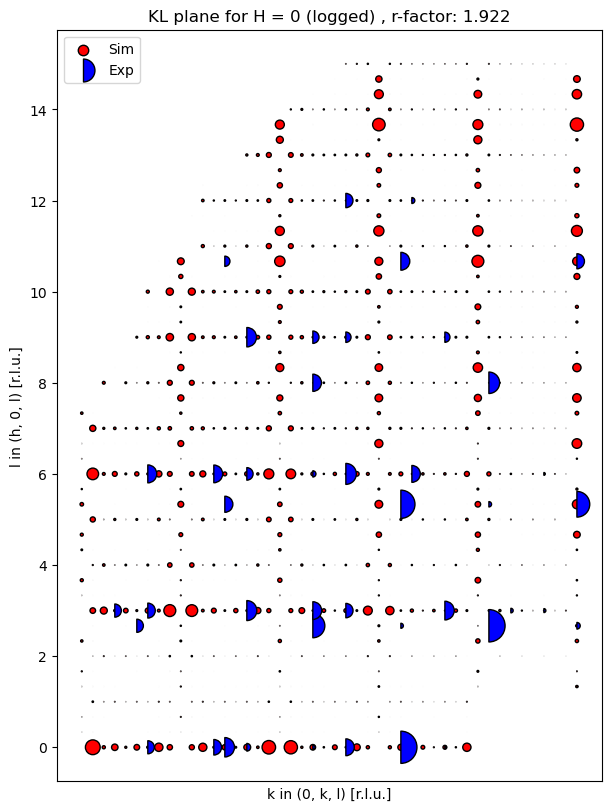

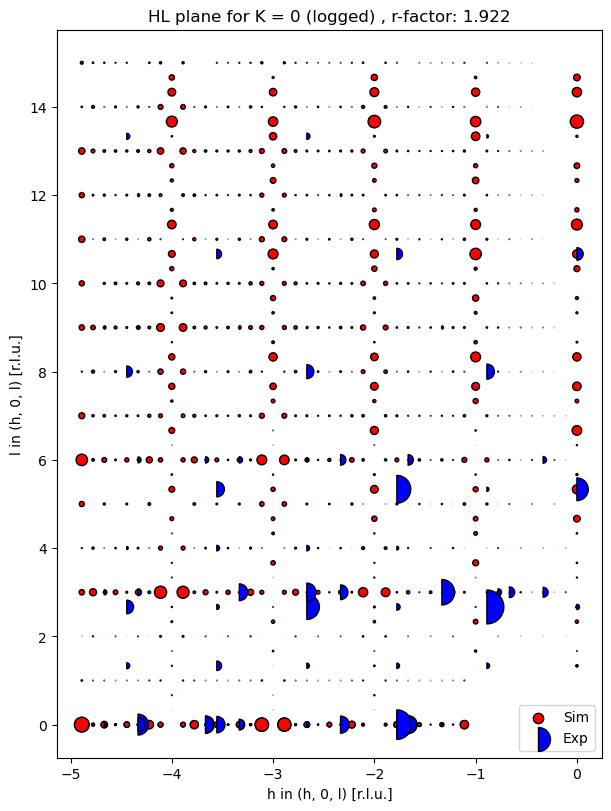

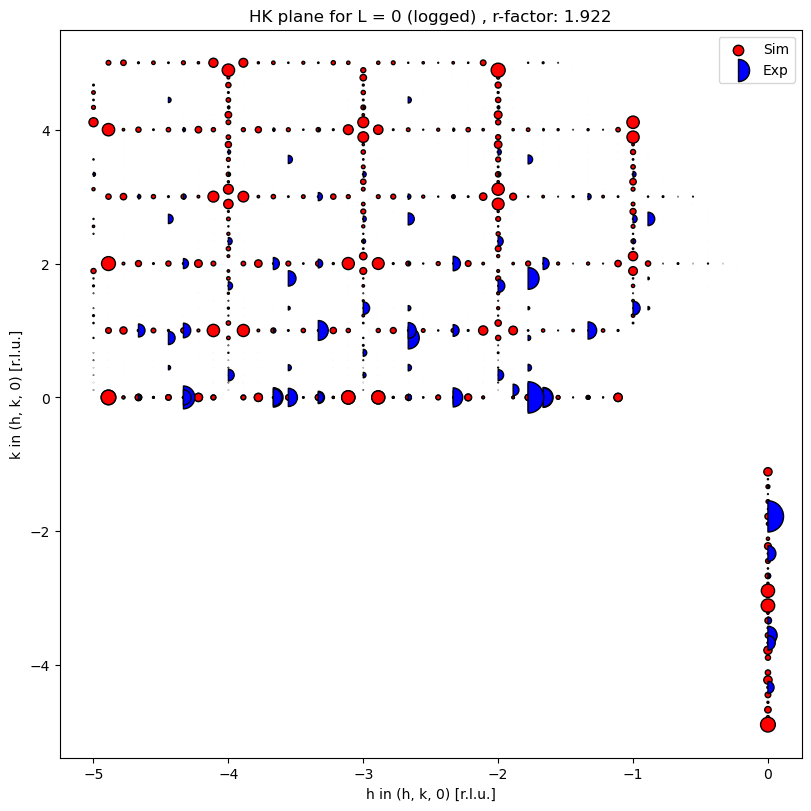

In [ ]:
exp_data = pd.read_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/PBCO/raw_data/combined_peaks_bragg.csv')

# random_seed = 42
# np.random.seed(random_seed)

n_features = exp_data.shape[0]
n_dim = 3
hkl_list = exp_data[["h", "k", "l"]].values.tolist()
np_hkl_list = np.array(hkl_list, dtype=np.float32)
child_hkl = parent_to_child_transform(np_hkl_list)
hkl_list = tf.convert_to_tensor(hkl_list, dtype=tf.float32)
features = hkl_list


labels = exp_data["intensity_exp"].tolist()
vol_err = exp_data["intensity_exp_err"].tolist()

labels = labels / np.sum(labels) * 60 # Normalize labels

best_model_pars = np.zeros(1290, dtype=np.float32)  # Initialize with zeros
# best_model_pars[120] = 15.59
# # # best_model_pars = np.concatenate((best_model_pars, one_best_model_pars), axis=0)  # Append one_best_model_pars

# # #initialise randomly
# best_model_pars = np.random.uniform(low=-1.0, high=1.0, size=1290  ).astype(np.float32)  # Initialize with random values

# best_model_pars = np.array([5.6,6.36,5.6,11.19,11.19,12.73,11.19,12.73,11.19,11.19,12.73,11.19,9.0,7.91,9.0,7.91,9.0,9.0,9.0,7.91,7.91,9.0,7.91,9.0,9.0,9.0,7.91,9.0,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,9.0,7.91,9.0,7.91,9.0,9.0,9.0,7.91,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,6.36,6.36,5.6,6.36,6.36,5.6,6.36,6.36,6.36,6.36,6.36,5.6,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,8.29,7.91,8.04,8.42,8.04,8.42,0.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,15.59,18.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,11.73,11.19,11.37,11.91,11.73,11.19,11.37,11.91,11.02,12.73,14.7,12.73,11.73,11.19,11.37,11.91,11.73,11.19,11.37,11.91,11.73,11.19,11.37,11.91,11.02,12.73,14.7,12.73,11.73,11.19,11.37,11.91,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,12.73,11.02,11.19,12.73,11.02,12.73,12.73,11.02,11.19,12.73,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,7.79,9.0,9.14,7.91,9.14,7.91,8.29,7.91,9.14,9.58,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,7.79,9.0,9.14,7.91,9.14,7.91,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,9.14,9.58,8.04,8.42,7.79,9.0,9.14,7.91,9.14,7.91,8.29,7.91,8.04,8.42,9.14,9.58,8.29,7.91,8.04,8.42,9.14,9.58,7.79,9.0,10.39,9.0,10.39,9.0,8.29,7.91,8.04,8.42,9.14,9.58,8.29,7.91,8.04,8.42,8.04,8.42,7.79,9.0,9.14,7.91,9.14,7.91,8.29,7.91,9.14,9.58,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,5.6,6.36,5.6,11.19,11.19,12.73,11.19,12.73,11.19,11.19,12.73,11.19,9.0,7.91,9.0,7.91,9.0,9.0,9.0,7.91,7.91,9.0,7.91,9.0,9.0,9.0,7.91,9.0,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,9.0,7.91,9.0,7.91,9.0,9.0,9.0,7.91,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,6.36,6.36,5.6,6.36,6.36,5.6,6.36,6.36,6.36,6.36,6.36,5.6,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,7.79,9.0,9.14,7.91,9.14,7.91,0.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,15.59,18.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,11.02,12.73,12.92,11.19,11.02,12.73,12.92,11.19,11.02,12.73,14.7,12.73,11.02,12.73,12.92,11.19,11.02,12.73,12.92,11.19,11.02,12.73,12.92,11.19,11.02,12.73,14.7,12.73,11.02,12.73,12.92,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,12.73,11.02,11.19,12.73,11.02,12.73,12.73,11.02,11.19,12.73,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,10.39,9.0,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,10.39,9.0,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,9.14,7.91,10.39,9.0,7.79,9.0,9.14,7.91,10.39,9.0,7.79,9.0,10.39,9.0,10.39,9.0,7.79,9.0,9.14,7.91,10.39,9.0,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,10.39,9.0,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,5.6,6.36,5.6,11.19,11.19,12.73,11.19,12.73,11.19,11.19,12.73,11.19,9.0,7.91,9.0,7.91,9.0,9.0,9.0,7.91,7.91,9.0,7.91,9.0,9.0,9.0,7.91,9.0,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,9.0,7.91,9.0,7.91,9.0,9.0,9.0,7.91,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,6.36,6.36,5.6,6.36,6.36,5.6,6.36,6.36,6.36,6.36,6.36,5.6,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,8.29,7.91,8.04,8.42,8.04,8.42,0.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,15.59,18.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,11.02,12.73,12.92,11.19,11.02,12.73,12.92,11.19,11.02,12.73,14.7,12.73,11.02,12.73,12.92,11.19,11.73,11.19,11.37,11.91,11.73,11.19,11.37,11.91,11.02,12.73,14.7,12.73,11.73,11.19,11.37,11.91,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,12.73,11.02,11.19,12.73,11.02,12.73,12.73,11.02,11.19,12.73,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,9.14,9.58,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,9.14,9.58,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,7.79,9.0,9.14,7.91,10.39,9.0,7.79,9.0,9.14,7.91,10.39,9.0,7.79,9.0,10.39,9.0,10.39,9.0,7.79,9.0,9.14,7.91,10.39,9.0,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,9.14,9.58,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,0.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,15.59,18.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,11.73,11.19,11.37,11.91,11.73,11.19,11.37,11.91,11.02,12.73,14.7,12.73,11.73,11.19,11.37,11.91,11.02,12.73,12.92,11.19,11.02,12.73,12.92,11.19,11.02,12.73,14.7,12.73,11.02,12.73,12.92,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,12.73,11.02,11.19,12.73,11.02,12.73,12.73,11.02,11.19,12.73,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,8.29,7.91,8.04,8.42,8.04,8.42,7.79,9.0,10.39,9.0,9.14,7.91,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,7.79,9.0,10.39,9.0,9.14,7.91,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,8.04,8.42,9.14,9.58,8.29,7.91,8.04,8.42,9.14,9.58,7.79,9.0,10.39,9.0,10.39,9.0,8.29,7.91,8.04,8.42,9.14,9.58,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,7.79,9.0,10.39,9.0,9.14,7.91,8.29,7.91,8.04,8.42,8.04,8.42,7.79,9.0,9.14,7.91,9.14,7.91,0.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,15.59,18.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,11.02,12.73,12.92,11.19,11.02,12.73,12.92,11.19,11.02,12.73,14.7,12.73,11.02,12.73,12.92,11.19,11.02,12.73,12.92,11.19,11.02,12.73,12.92,11.19,11.02,12.73,14.7,12.73,11.02,12.73,12.92,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,12.73,11.02,11.19,12.73,11.02,12.73,12.73,11.02,11.19,12.73,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,10.39,9.0,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,10.39,9.0,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,9.14,7.91,10.39,9.0,7.79,9.0,9.14,7.91,10.39,9.0,7.79,9.0,10.39,9.0,10.39,9.0,7.79,9.0,9.14,7.91,10.39,9.0,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,10.39,9.0,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91])
# strain_modes = [111, 411, 711, 906, 1101]
# for index in strain_modes:
#     best_model_pars[index] = 0.0

best_model_pars = tf.convert_to_tensor(best_model_pars, dtype=tf.float32)   


exp_data = pd.read_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/PBCO/raw_data/combined_peaks_bragg.csv')
hkl_list = exp_data[["h", "k", "l"]].values.tolist()
hkl_list = tf.convert_to_tensor(hkl_list, dtype=tf.float32)

matrix = np.loadtxt('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/PBCO/new_PBCO_fit/matrix.txt', dtype=np.float32)
#converrt matrix to tensor
matrix = tf.convert_to_tensor(matrix, dtype=tf.float32)
exp_data['intensity_sim'] = fun_tf(features, best_model_pars , matrix).numpy()

child_exp_data = exp_data['intensity_exp'].tolist()
child_sim_data = exp_data['intensity_sim'].tolist()
child_frame = pd.DataFrame({
    'h': child_hkl[:,0] , 
    'k': child_hkl[:,1] , 
    'l': child_hkl[:,2],
    'intensity_exp': child_exp_data, 
    'intensity_sim': child_sim_data })



r_factor = alris_r_factor(exp_data)
print(f"ALRIS R-factor: {r_factor:.3f}")

child_r_factor = alris_r_factor(child_frame)
print(f"Child R-factor: {child_r_factor:.3f}")

fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM1(axs, exp_data, r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM2(axs, exp_data, r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(8,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM3(axs, exp_data, r_factor, 0,norm_plane=True)
plt.show()


In [7]:


def plot_plane_sim_vs_exp_DIM2(ax, df,r_factor, norm_plane=False):
    #only extract data for h == 0
    exp_data_0 = df.loc[df['k'] == 0].copy()
    if norm_plane:
        exp_data_0['intensity_exp'] = exp_data_0['intensity_exp'] / np.sum(exp_data_0['intensity_exp']) * 60
    
    ax.scatter(exp_data_0['h'], exp_data_0['l'], 
               s=np.log10(exp_data_0['intensity_sim'] + 1) * 500 , color='red', edgecolor="black",
               label='Sim', marker=MarkerStyle("o"))
    ax.scatter(exp_data_0['h'] , exp_data_0['l'] , s=np.log10(exp_data_0['intensity_exp'] + 1) * 500, color='blue', edgecolor="black",
                label='Exp', marker=MarkerStyle("o", fillstyle="right"))
    
    # #grid on
    # ax.grid(True, linestyle='--', alpha=0.7)
    # #adjust x axis ticks
    # ax.set_xticks(np.arange(0, -5, 0.11))
    # ax.set_yticks(np.arange(0, 15, 0.11))
    ax.set_xlabel(f"h in (h, 0, l) [r.l.u.]")
    ax.set_ylabel(f"l in (h, 0, l) [r.l.u.]")
    ax.set_title(f"HL plane for K = 0 (logged) , r-factor: {r_factor:.3f}")
    ax.legend()
    # ax.set_xlim(0 , -5.01)
    # ax.set_ylim(-1.01 , 3)


def plot_plane_sim_vs_exp_DIM1(ax, df, r_factor, norm_plane=False):
    
    exp_data_0 = df.loc[df['h'] == 0].copy()
    if norm_plane:
        exp_data_0['intensity_exp'] = exp_data_0['intensity_exp'] / np.sum(exp_data_0['intensity_exp']) * 60
    
    ax.scatter(exp_data_0['k'], exp_data_0['l'], 
               s=np.log10(exp_data_0['intensity_sim'] + 1)* 500 , color='red', edgecolor="black",
               label='Sim', marker=MarkerStyle("o"))
    ax.scatter(exp_data_0['k'] , exp_data_0['l'] , s=np.log10(exp_data_0['intensity_exp'] + 1)* 500 , color='blue', edgecolor="black",
               label='Exp', marker=MarkerStyle("o", fillstyle="right"))
    
    #grid on
    # ax.grid(True, linestyle='--', alpha=0.7)
    # #adjust x axis ticks
    ax.set_xticks(np.arange(0, -6, 0.33))
    #ax.set_yticks(np.arange(0, 15, 0.11))
    ax.set_xlabel(f"k in (0, k, l) [r.l.u.]")
    ax.set_ylabel(f"l in (h, 0, l) [r.l.u.]")
    ax.set_title(f"KL plane for H = 0 (logged) , r-factor: {r_factor:.3f}")
    ax.legend()



def plot_plane_sim_vs_exp_DIM3(ax, df, r_factor, l,norm_plane=False):
    exp_data_0 = df.loc[df['l'] == 0].copy()
    if norm_plane:
        exp_data_0['intensity_exp'] = exp_data_0['intensity_exp'] / np.sum(exp_data_0['intensity_exp']) * 60
    
    ax.scatter(exp_data_0['h'], exp_data_0['k'], 
            s=np.log10(exp_data_0['intensity_sim'] + 1)* 500 , color='red', edgecolor="black",
            label='Sim', marker=MarkerStyle("o"))
    ax.scatter(exp_data_0['h'] , exp_data_0['k'] , s=np.log10(exp_data_0['intensity_exp'] + 1)* 500 , color='blue', edgecolor="black",
            label='Exp', marker=MarkerStyle("o", fillstyle="right"))
    
    #adjust x axis ticks
    # ax.set_xticks(np.arange(0, -5, 0.11))
    # ax.set_yticks(np.arange(0, -5, 0.11))
    ax.set_xlabel(f"h in (h, k, {l}) [r.l.u.]")
    ax.set_ylabel(f"k in (h, k, {l}) [r.l.u.]")
    ax.set_title(f"HK plane for L = 0 (logged) , r-factor: {r_factor:.3f}")
    ax.legend()

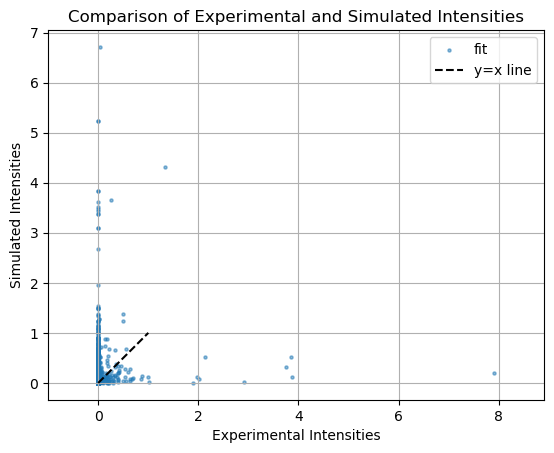

In [24]:
x = np.linspace(0 ,1, 10000)
y = x
plt.scatter(exp_data['intensity_exp']/np.sum(exp_data['intensity_exp']) * 60, exp_data['intensity_sim'], s=5, alpha=0.5 , label='fit')
plt.plot(x , y, color='black', linestyle='--', label='y=x line')
plt.legend()
plt.grid(True)
plt.title('Comparison of Experimental and Simulated Intensities')
plt.xlabel('Experimental Intensities')
plt.ylabel('Simulated Intensities')
plt.axis('equal')
plt.show()

# convert hkl

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from visualiser_function1 import shift_atoms, transform_list_hkl_p63_p65, get_structure_factors , atom_position_list
from itertools import chain
from matplotlib.markers import MarkerStyle
from tqdm import tqdm
from time import time

In [2]:
def fun_tf1(x, pars):
    """
    Fast computation of structure factors with parameter-dependent structure.
        # Get modified structure
    modified_struct = shift_atoms_p65(*pars)
    neg_h = tf.stack([-x[:, 0], x[:, 1], x[:, 2]], axis=1)
    x_combined = tf.concat([x, neg_h], axis=0)  # Shape [2N, 3]

    x_combined = transform_list_hkl_p63_p65(x_combined)
    
    # Get structure factors
    sf_combined = get_structure_factors(x_combined, modified_struct)
    # Compute intensity
    # Split and compute intensity
    sf_hkl = sf_combined[:tf.shape(x)[0]]
    sf_neg_k = sf_combined[tf.shape(x)[0]:]
    
    intensity = (tf.abs(sf_hkl) + tf.abs(sf_neg_k)) ** 2
    return intensity / tf.reduce_max(intensity)
    """

    # Get modified structure
    pars_tensor = tf.stack(pars)  # shape (445,)
    # Set specific indices to zero using TensorFlow ops
    indices_to_zero = [43, 148, 253, 318, 383]
    mask = tf.ones_like(pars_tensor)
    mask = tf.tensor_scatter_nd_update(mask, [[i] for i in indices_to_zero], [0.0]*len(indices_to_zero))
    pars_tensor = pars_tensor * mask

    # Continue with TensorFlow ops
    atom_shift_list = shift_atoms(*tf.unstack(pars_tensor))
    print(f"Shape of atom_shift_list: {len(atom_shift_list)}")

    # Flatten atom_shift_list if it contains nested lists
    flat_atom_shift_list = list(chain.from_iterable(
        x if isinstance(x, list) else [x] for x in atom_shift_list
    ))
    modified_struct = atom_position_list(*flat_atom_shift_list)

    #neg_h = tf.stack([-x[:, 0], x[:, 1], x[:, 2]], axis=1)
    x_combined = x
    #x_combined = tf.concat([x, neg_h], axis=0)  # Shape [2N, 3]
    parent_hkl = x_combined
    x_combined = transform_list_hkl_p63_p65(x_combined)


    print(f"Shape of x_combined: {x_combined.shape}")

    # Get structure factors
    sf_hkl = get_structure_factors(x_combined, modified_struct, parent_hkl)
    # Compute intensity
    # Split and compute intensity
    # sf_hkl = sf_combined[:tf.shape(x)[0]
    print(f"Shape of sf_hkl: {sf_hkl.shape}")
    
    intensity = (abs(sf_hkl)) ** 2
    max_intensity = tf.reduce_max(intensity)
    print(f"Max intensity: {max_intensity.numpy()}")
    #w = tf.constant(0.00048773325893810833, dtype=tf.float32)  # Debye-Waller factor 
    #w = tf.constant(0, dtype=tf.float32)  # Debye-Waller factor 
    qnorms = tf.norm(tf.cast(x_combined, tf.float32), axis=1)
    # qnorms = tf.reshape(qnorms, (-1, 1))  # Reshape to match the shape of intensity
    intensity = intensity * tf.exp(- 0* qnorms ** 2)  # Apply Debye-Waller factor
    #intensity = log10(intensity + 1)  # Convert to log10 scale
    intensity = intensity / tf.reduce_sum(intensity) * 60
    #intensity = tf.where(intensity < 0.189, 0.0, intensity)  # Replace values below threshold with 0
    return intensity


In [3]:

def alris_r_factor(data):
    exp_intensity = data['intensity_exp'] / np.sum(data['intensity_exp']) * 60
    #simulated_intensity = 0
    simulated_intensity = data['intensity_sim']
    alris_r_factor = np.sum(np.abs(exp_intensity - simulated_intensity)) / np.sum(np.abs(exp_intensity))
    return alris_r_factor



In [4]:
def parent_to_child_transform(hkl_list):
    """
    Transform the parent hkl to child hkl
    """
    a = 3.82030
    b = 3.88548
    c = 11.68350
    hkl_list = tf.convert_to_tensor(hkl_list, dtype=tf.float32)

    # Apply the transformation using TensorFlow operations
    # h_new = -  hkl_list[:, 0] / 9
    # k_new = hkl_list[:, 2]
    # l_new = hkl_list[:, 1] / 9

    h_new = hkl_list[:, 0] * 9
    k_new = hkl_list[:, 2] 
    l_new = hkl_list[:, 1] * 9

        # Stack the new h, k, l components into a single tensor
    result = np.stack([h_new, k_new, l_new] , axis=1)

    return result

In [10]:
exp_data1 = pd.read_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/PBCO/raw_data/combined_peaks_bragg.csv')

n_features = exp_data1.shape[0]
n_dim = 3
hkl_list = exp_data1[["h", "k", "l"]].values.tolist()
np_hkl_list = np.array(hkl_list, dtype=np.float32)
child_hkl = parent_to_child_transform(np_hkl_list)
hkl_list = tf.convert_to_tensor(hkl_list, dtype=tf.float32)
features = hkl_list


labels = exp_data1["intensity_exp"].tolist()
vol_err = exp_data1["intensity_exp_err"].tolist()

labels = labels / np.sum(labels) * 60 # Normalize labels

best_model_pars = np.zeros(445, dtype=np.float32)  # Initialize with zeros
best_model_pars = tf.convert_to_tensor(best_model_pars, dtype=tf.float32)   


exp_data1 = pd.read_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/PBCO/raw_data/combined_peaks_bragg.csv')
hkl_list = exp_data1[["h", "k", "l"]].values.tolist()
hkl_list = tf.convert_to_tensor(hkl_list, dtype=tf.float32)
exp_data1['intensity_sim'] = fun_tf1(features, best_model_pars).numpy()

child_exp_data = exp_data1['intensity_exp'].tolist()
child_sim_data = exp_data1['intensity_sim'].tolist()
child_frame = pd.DataFrame({
    'h': child_hkl[:,0] , 
    'k': child_hkl[:,1] , 
    'l': child_hkl[:,2],
    'intensity_exp': child_exp_data, 
    'intensity_sim': child_sim_data })


#replace values below 1e-5 with 0
#exp_data['intensity_sim'] = np.where(exp_data['intensity_sim'] < 0.0058, 0, exp_data['intensity_sim'])

r_factor = alris_r_factor(exp_data1)
print(f"ALRIS R-factor: {r_factor:.3f}")

child_r_factor = alris_r_factor(child_frame)
print(f"Child R-factor: {child_r_factor:.3f}")

res is True
Shape of atom_shift_list: 445
hello world
Shape of x_combined: (12818, 3)
F_hkl: tf.Tensor(
[ 2.5452127e+04+0.j         -5.6472778e-02+0.0001564j
 -2.3417711e-01-0.00011396j ...  5.1743098e-02-0.00045323j
  1.9349521e-01-0.00058369j  1.3538985e-01+0.00032384j], shape=(12818,), dtype=complex64)
Shape of sf_hkl: (12818,)
Max intensity: 647810752.0
ALRIS R-factor: 1.996
Child R-factor: 1.996


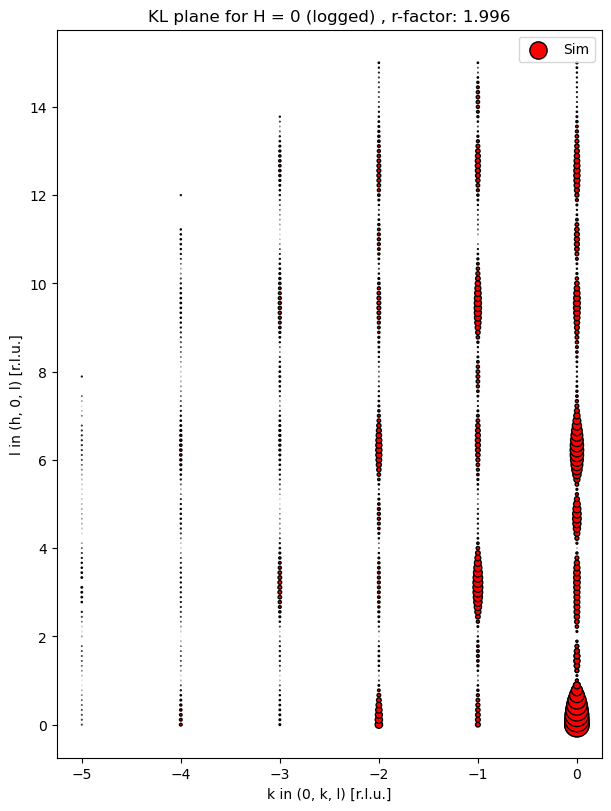

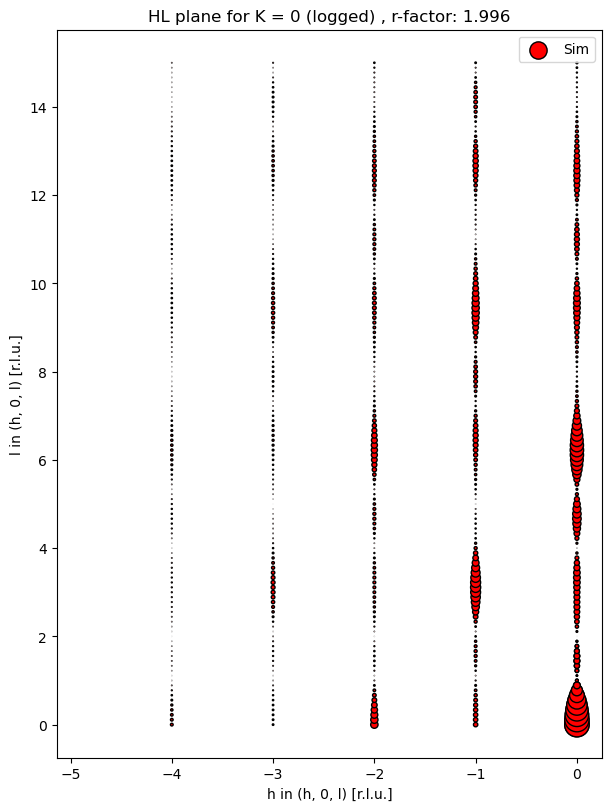

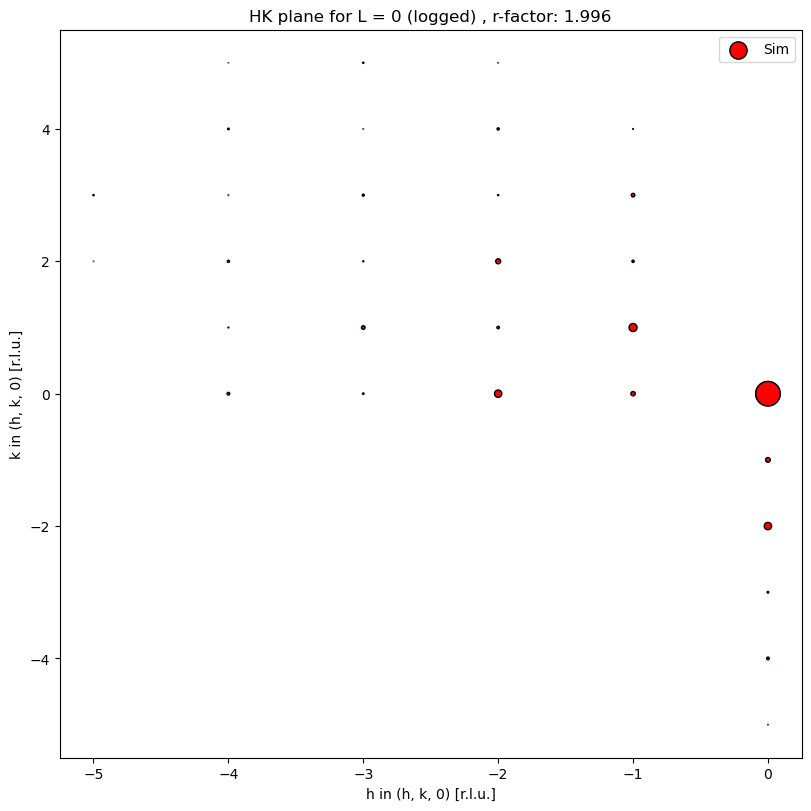

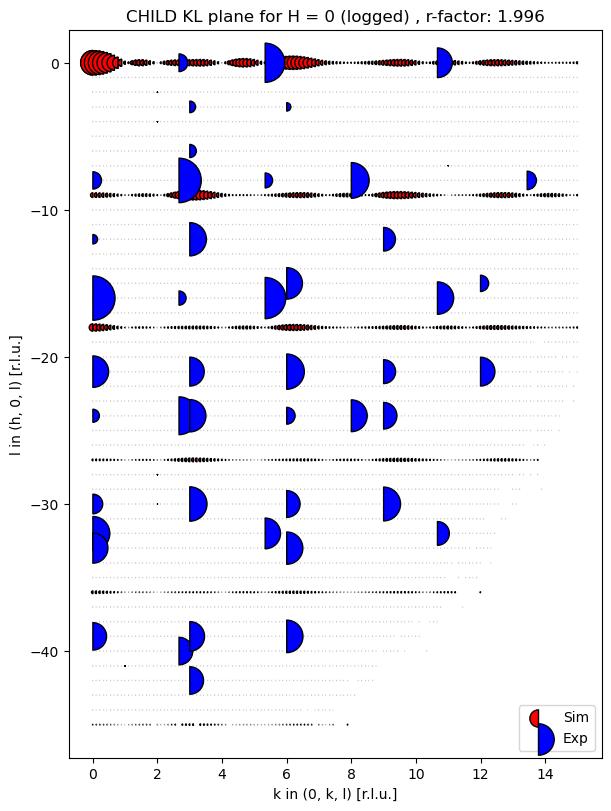

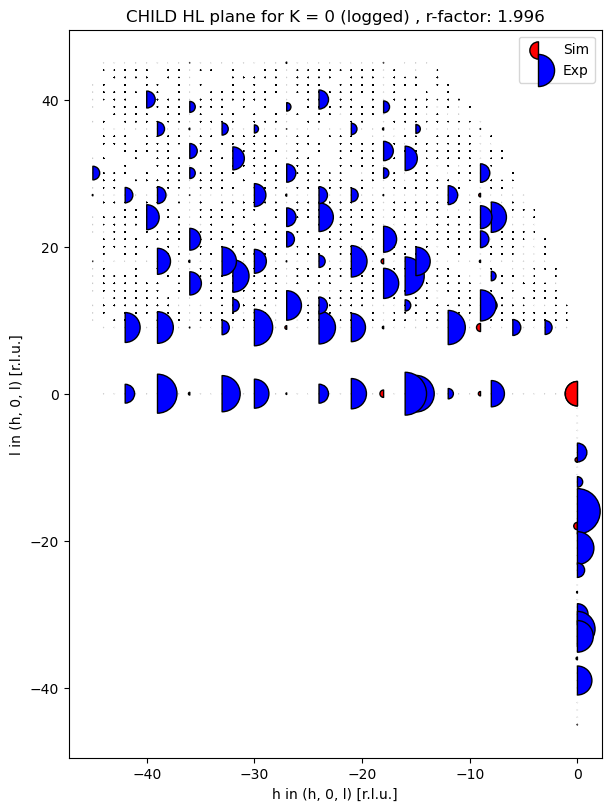

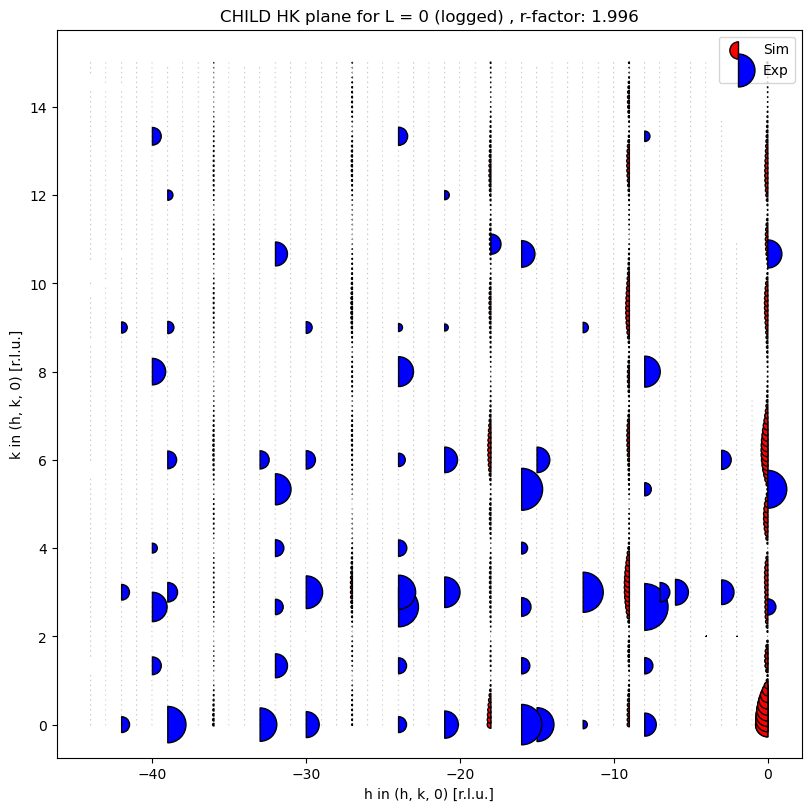

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)

#extract from rows 1 to 5415


plot_plane_sim_vs_exp_DIM1(axs, exp_data1, r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM2(axs, exp_data1, r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(8,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM3(axs, exp_data1, r_factor, 0,norm_plane=True)
plt.show()




# #extract from rows 1 to 5415
# child_data_DIM1 = child_frame.iloc[0:5415, :].copy()

# #extract from rows 5416 to 11203
# child_data_DIM2 = child_frame.iloc[5415:11203, :].copy()

# #extract from rows 11204 to end
# child_data_DIM3 = child_frame.iloc[11203:, :].copy()

fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM1_CHILD(axs, child_frame, child_r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM2_CHILD(axs, child_frame, child_r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(8,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM3_CHILD(axs, child_frame, child_r_factor, 0,norm_plane=True)
plt.show()


# La2CuO4

In [2]:
def LCO_fun_tf(x, pars):
    """
    Fast computation of structure factors with parameter-dependent structure.
        # Get modified structure
    modified_struct = shift_atoms_p65(*pars)
    neg_h = tf.stack([-x[:, 0], x[:, 1], x[:, 2]], axis=1)
    x_combined = tf.concat([x, neg_h], axis=0)  # Shape [2N, 3]

    x_combined = transform_list_hkl_p63_p65(x_combined)

    # Get structure factors
    sf_combined = get_structure_factors(x_combined, modified_struct)
    # Compute intensity
    # Split and compute intensity
    sf_hkl = sf_combined[:tf.shape(x)[0]]
    sf_neg_k = sf_combined[tf.shape(x)[0]:]
    
    intensity = (tf.abs(sf_hkl) + tf.abs(sf_neg_k)) ** 2
    return intensity / tf.reduce_max(intensity)
    """
    # Get modified structure
    atom_shift_list = shift_atoms(*pars)
    print(f"Shape of atom_shift_list: {len(atom_shift_list)}")



    # Flatten atom_shift_list if it contains nested lists
    flat_atom_shift_list = list(chain.from_iterable(
        x if isinstance(x, list) else [x] for x in atom_shift_list
    ))
    modified_struct = atom_position_list(*flat_atom_shift_list)

    #neg_h = tf.stack([-x[:, 0], x[:, 1], x[:, 2]], axis=1)
    x_combined = x
    #x_combined = tf.concat([x, neg_h], axis=0)  # Shape [2N, 3]

    x_combined = transform_list_hkl_p63_p65(x_combined)
    
    # Get structure factors
    sf_combined = get_structure_factors(x_combined, modified_struct)
    # Compute intensity
    # Split and compute intensity
    sf_hkl = sf_combined[:tf.shape(x)[0]]
    
    print(f"Shape of sf_combined: {sf_combined.shape}, Shape of x_combined: {x_combined.shape}")
    
    intensity = (tf.abs(sf_hkl)) ** 2
    # w = tf.constant(0.00159, dtype=tf.float32)  # Debye-Waller factor is 0.00159
    w = tf.constant(0, dtype=tf.float32)  # Debye-Waller factor is 0.00159
    qnorms = tf.norm(tf.cast(x_combined[:tf.shape(x)[0]], tf.float32), axis=1)
    # qnorms = tf.reshape(qnorms, (-1, 1))  # Reshape to match the shape of intensity
    intensity = intensity * tf.exp(-w * qnorms ** 2)  # Apply Debye-Waller factor
    #intensity = log10(intensity + 1)  # Convert to log10 scale
    intensity_summed = tf.reduce_sum(intensity)  # Sum intensity for normalization
    intensity_unscaled = intensity  # Store unscaled intensity
    intensity_scaled = intensity  * 30 / intensity_summed
    return intensity_scaled , intensity_summed , intensity_unscaled


In [3]:
def LCO_parent_to_child_transform(hkl_list):
    """
    Transform the parent hkl to child hkl
    """
    h_new = 2 * hkl_list[:, 2]
    k_new = 4 * hkl_list[:, 0]
    l_new = hkl_list[:, 1]

        # Stack the new h, k, l components into a single tensor
    result = np.stack([h_new, k_new, l_new] , axis=1)

    return result



def LCO_alris_r_factor(data):
    exp_intensity = data['intensity_exp'] / np.sum(data['intensity_exp']) * 30
    simulated_intensity = data['intensity_sim']
    alris_r_factor = np.sum(np.abs(exp_intensity - simulated_intensity)) / np.sum(np.abs(exp_intensity))
    return alris_r_factor



In [4]:
exp_data = pd.read_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/La2CuO4/raw_data/peaks1.csv')

n_features = exp_data.shape[0]
n_dim = 3
hkl_list = exp_data[["h", "k", "l"]].values.tolist()
np_hkl_list = np.array(hkl_list, dtype=np.float32)
child_hkl = LCO_parent_to_child_transform(np_hkl_list)
hkl_list = tf.convert_to_tensor(hkl_list, dtype=tf.float32)
features = hkl_list


labels = exp_data["intensity_exp"].tolist()


labels = labels / np.sum(labels) * 30 # Normalize labels

best_model_pars = np.zeros(20, dtype=np.float32)  # Initialize with zeros
best_model_pars = tf.convert_to_tensor(best_model_pars, dtype=tf.float32)   


exp_data = pd.read_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/La2CuO4/raw_data/peaks1.csv')
hkl_list = exp_data[["h", "k", "l"]].values.tolist()
hkl_list = tf.convert_to_tensor(hkl_list, dtype=tf.float32)
intensity, intensity_summed , intensity_unscaled = LCO_fun_tf(features, best_model_pars)
exp_data['intensity_sim'] = intensity

child_exp_data = exp_data['intensity_exp'].tolist()
child_sim_data = intensity
child_frame = pd.DataFrame({
    'h': child_hkl[:,0] , 
    'k': child_hkl[:,1] , 
    'l': child_hkl[:,2],
    'intensity_exp': child_exp_data, 
    'intensity_sim': child_sim_data })


#replace values below 1e-5 with 0
#exp_data['intensity_sim'] = np.where(exp_data['intensity_sim'] < 0.0058, 0, exp_data['intensity_sim'])

r_factor = LCO_alris_r_factor(exp_data)
print(f"ALRIS R-factor: {r_factor:.3f}")

child_r_factor = LCO_alris_r_factor(child_frame)
print(f"Child R-factor: {child_r_factor:.3f}")

Shape of atom_shift_list: 156
Shape of sf_combined: (67,), Shape of x_combined: (67, 3)
ALRIS R-factor: 1.127
Child R-factor: 1.127


In [5]:
def plot_plane_sim_vs_exp(ax, df, k, min_loss , r_factor , norm_plane=False):
    exp_data_0 = df.loc[df['k'] == k].copy()
    if norm_plane:
        #exp_data_0['intensity_sim'] = exp_data_0['intensity_sim'] / np.sum(exp_data_0['intensity_sim'])
        exp_data_0['intensity_exp'] = exp_data_0['intensity_exp'] / np.sum(exp_data_0['intensity_exp']) * 30
    
    ax.scatter(exp_data_0['h'], exp_data_0['l'], 
               s=exp_data_0['intensity_sim'] * 100, color='red', edgecolor="black",
               label='Sim', marker=MarkerStyle("o", fillstyle="right"))
    ax.scatter(exp_data_0['h'], exp_data_0['l'], 
               s=exp_data_0['intensity_exp'] * 100 , color='blue', edgecolor="black",
               label='Exp', marker=MarkerStyle("o", fillstyle="left"))
    
    ax.set_xlabel(f"h in (h, {k}, l) [r.l.u.]")
    ax.set_ylabel(f"l in (h, {k}, l) [r.l.u.]")
    ax.set_title(f"k = {k} , min loss = {min_loss:.4f}, r-factor (normalised)= {r_factor:.4f}")
    ax.legend()


def plot_plane_sim_vs_exp1(ax, df, l,  min_loss , r_factor , norm_plane=False):
    exp_data_0 = df.loc[df['l'] == l].copy()
    if norm_plane:
        #exp_data_0['intensity_sim'] = exp_data_0['intensity_sim'] / np.sum(exp_data_0['intensity_sim'])
        exp_data_0['intensity_exp'] = exp_data_0['intensity_exp'] / np.sum(exp_data_0['intensity_exp']) * 30
    
    ax.scatter(exp_data_0['h'], exp_data_0['k'], 
               s=exp_data_0['intensity_sim'] * 100, color='red', edgecolor="black",
               label='Sim', marker=MarkerStyle("o", fillstyle="right"))
    ax.scatter(exp_data_0['h'], exp_data_0['k'], 
               s=exp_data_0['intensity_exp'] * 100, color='blue', edgecolor="black",
               label='Exp', marker=MarkerStyle("o", fillstyle="left"))
    
    ax.set_xlabel(f"h in (h, k, {l}) [r.l.u.]")
    ax.set_ylabel(f"k in (h, k, {l}) [r.l.u.]")
    ax.set_title(f"l = {l} , min loss = {min_loss:.4f}, r-factor (normalised)= {r_factor:.4f}")
    ax.legend()

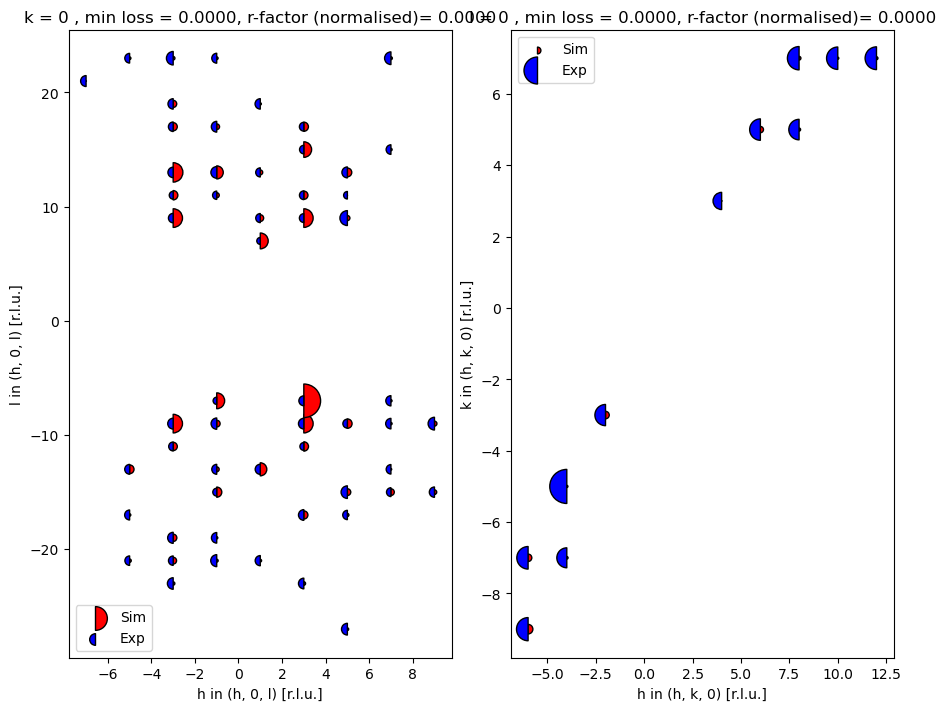

In [6]:
# Prepare subplot grid
fig, axs = plt.subplots(1, 2, figsize=(9, 7), constrained_layout=True)
plt.style.use('default')
plot_plane_sim_vs_exp(axs[0], exp_data, 0, 0 ,0, norm_plane=True)
plot_plane_sim_vs_exp1(axs[1], exp_data, 0,0 ,0, norm_plane=True)